# Labeling Disaster-Related Messages

<img src='./images/wordcloud.png'>

### Problem
Given text data of disaster-related messages and news bulletins (English / English translation), can we correctly assign labels (tags) to the message?

> The task will involve **Natural Language Processing** (*NLP*) analysis.

https://appen.com/datasets/combined-disaster-response-data/

### Objective
Our goal is to create a model that can interpret and label a message using **Natural Language Processing**. There are **37** important labels that a message can have (for example if the message is *requesting medical help* or *offering aid*).

In order to simplify the given dataset, I will be working only with a single label: `aid-related`.

> **Question:** Can we create a model that can correctly label a message as being **aid-related** using only the message itself?

### Success Criteria
We will be using `recall_score`, `precision_score`, `f1-score`, and `accuracy_score` to assess our models.
***
#### Metrics & Loss
##### Recall Score
The recall score of a prediction is the ratio of **correct true positives** to **total positive samples**. *Recall only considers the correctness of samples that are actually `true`.*
> $\LARGE {Recall} = \frac{TP}{TP + FN}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/2 (0.5) true positives correctly labeled.
>>> recall_score(y_true, y_pred)
>>> 0.5
```
***
##### Precision Score
The precision score of a prediction is the ratio of **correct positive predictions** to **total positive predictions.** *Precision only considers samples where the prediction is `true`.*
> $\LARGE {Precision} = \frac{TP}{TP + FP}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/3 (0.33) predicted positives are correctly labeled.
>>> precision_score(y_true, y_pred)
>>> 0.3333333333333333
```
***
##### F1-Score
> *Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.*
>
> *The F-measure (and measures) can be interpreted as a weighted harmonic mean of the precision and recall.*
> https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
> 
> $\LARGE {f_1} = 2 \times \frac{precision \times recall}{precision + recall}$


```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 2 * ((0.333 * 0.5) / (0.333 + 0.5)) = 0.3999759990399616
>>> f1_score(y_true, y_pred)
>>> 0.4
```
***
##### Accuracy Score
The accuracy of a prediction is the ratio of **correct labels** to **total labels**. *The accuracy takes into account all of the models predictions, but can be misleading with imbalanced label distributions.*
> 
> $\LARGE {accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/4 (0.25) correctly labeled predictions.
>>> accuracy_score(y_true, y_pred)
>>> 0.25
```
***
##### Binary Cross-Entropy
Binary Cross-Entropy (*log-loss*) measures the loss based on how wrong the model's predictions are.

Unlike other metrics used, Binary Cross-Entropy is able to measure continuous entries rather than just binary.

$\LARGE {cross entropy} = -\sum_{c=1}^My_{o,c}\log(p_{o,c})$

> *Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.*
>
> *https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html*

```python
>>> # For samples guessed relatively close to the actual values, the log loss will be low.
>>> y_true = np.array([0.  , 0.  , 1.  , 1.  ])
>>> y_pred = np.array([0.15, 0.15, 0.9 , 1.  ])
>>> 
>>> binary_crossentropy(y_true, y_pred).numpy()
>>> 0.1075995070620419
>>>
>>> # However, bad predictions will have a large effect on the loss.
>>> y_true = np.array([0.  , 0.  , 1.  , 1.  ])
>>> y_pred = np.array([0.85, 0.15, 0.9 , 1.  ]) # First guess is very off.
>>> 
>>> binary_crossentropy(y_true, y_pred).numpy()
>>> 0.5412496336542204
```

Again, ***a perfect model would have a log loss of 0.***

### Imports

In [2]:
import sys

# the ./support dir contains disaster_response.py
sys.path.append('./support')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

import os
import html
import string
from IPython.display import clear_output
import joblib

from gensim.models import Word2Vec

from sklearn.metrics import (f1_score, recall_score, 
                             precision_score, accuracy_score)

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras import (
    layers, models, initializers, regularizers, constraints, optimizers
)
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import spacy

import kerastuner as kt

# Custom functions and classes for this project.
import disaster_response as dis 

In [4]:
# Check that GloVe model exists in the correct directory.
dis.check_for_glove()

# Plot formatting.
plt.style.use(['ggplot', 'seaborn-talk'])

# Set colors for plotting.
COLORS = {
    'blue': '#1f77b4',
    'green': '#2eb41f',
    'yellow': '#b4b21f',
    'red': '#b41f1f',
    'purple': '#b41f94',
    'grey': '#e5e5e5'
}

# Check for device.
print(dis.headerize(tf.test.gpu_device_name()))

# Initialize results_df
results_df = dis.make_scores_df()

********************************************************************************
*                         SUCCESS - GloVe Model Found                          *
********************************************************************************
********************************************************************************
*                                /device:GPU:0                                 *
********************************************************************************
********************************************************************************
*                        DataFrame Created Sucessfully                         *
********************************************************************************


In [5]:
# Function to add scores to results_df.
def assign_scores(df, column_name, scores):
    df[column_name] = scores
    return df

## Data Understanding
### Load in data.

In [6]:
# Checking that the necessary files are in the default directory.
os.listdir('./data/')

['.ipynb_checkpoints',
 'column_descriptions.csv',
 'disaster_response_messages_test.csv',
 'disaster_response_messages_training.csv',
 'disaster_response_messages_validation.csv']

In [7]:
# Load in data.
dw = dis.DataWarehouse()

********************************************************************************
*                           Data loaded sucessfully.                           *
********************************************************************************
********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Training Data:
	(21046, 42)
Val Data:
	(2573, 42)
Test Data:
	(2629, 42)

Column Descriptions:
	(20, 1)


### Explore data.

In [8]:
dw.train.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [9]:
dw.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 42 columns):
id                        21046 non-null int64
split                     21046 non-null object
message                   21046 non-null object
original                  8191 non-null object
genre                     21046 non-null object
related                   21046 non-null int64
PII                       21046 non-null int64
request                   21046 non-null int64
offer                     21046 non-null int64
aid_related               21046 non-null int64
medical_help              21046 non-null int64
medical_products          21046 non-null int64
search_and_rescue         21046 non-null int64
security                  21046 non-null int64
military                  21046 non-null int64
child_alone               21046 non-null int64
water                     21046 non-null int64
food                      21046 non-null int64
shelter                   21046 non-null i

- There are a couple columns that are strings (that we'll be working with with NLP).
```python
['message', 'genre']
```
- There are many missing values in the `original` column.
- There is an `id` column which can be dropped.
- There are 37 potential target columns (labels) that are binary.

In [10]:
dw.train['genre'].value_counts()

news      10450
direct     8666
social     1930
Name: genre, dtype: int64

In [11]:
# Check the integrity of the `message` column when the `original` is missing.
dw.train[dw.train['original'].isna()]['message'].head()

5973             NOTES: It mark as not enough information
7956    My thoughts and prayers go out to all the live...
7957    lilithia yes 5.2 magnitude earthquake hit mani...
7958    RT TheNewsBlotter RT caribnews On Call Interna...
7959    Most Eureka homeowners won&#39 t collect on qu...
Name: message, dtype: object

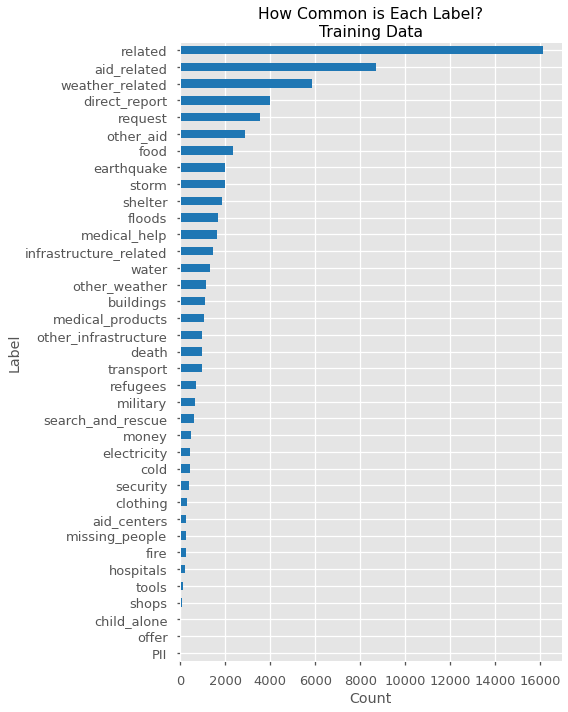

In [12]:
# Plot label-counts within the training data.
label_counts = dw.train[dw.target_columns].sum().sort_values()

fig, ax = plt.subplots(figsize=(8, 10))
label_counts.plot(kind='barh', color=COLORS['blue'])
ax.set(title='How Common is Each Label?\nTraining Data',
       ylabel='Label',
       xlabel='Count')
fig.tight_layout()

- Some labels are non-existent in the training data which should prove to be a problem.

### Understand what the columns mean.

In [13]:
dw.column_descriptions

,Description
Column,
id,Unique ID for each individual row
split,"Test, tune, validation split"
message,English text of actual messages related to dis...
original,Text of column 3 in native language as origina...
genre,"Type of message, including direct messages, so..."
related,"Is the message disaster related? 1= yes, 2=no"
PII,"Does the message contain PII? 1= yes, 2=no"
request,"Does the message contain a request? 1= yes, 2=no"
offer,"Does the message contain an offer? 1= yes, 2=no"


- This is pretty predictable. The `message` column has text data (sometimes english translated). Each of the label columns is binary.
  - There is a typo in the label column descriptions: `{1: 'yes', 0: 'no'}`

### What kind of cleaning is required?
1. Drop columns `['id', 'split']`.
2. Examine the text for abnormalities.
3. Combine all the text into one column.
4. Process the text data.
 1. Load in a pre-trained GloVe model. (https://nlp.stanford.edu/projects/glove/)
 2. Fit text on the GloVe model into matrix.

## Data Preparation
### Text Data

In [14]:
dw.show_data_shapes()

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 42)
Processed Val Data:
	(2573, 42)
Processed Test Data:
	(2629, 42)


#### Drop unnecessary columns.

In [15]:
dw.drop_column(['id', 'split'])

********************************************************************************
*                                   Success                                    *
********************************************************************************
Columns dropped:
	 ['id', 'split']

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 40)
Processed Val Data:
	(2573, 40)
Processed Test Data:
	(2629, 40)


#### Examine abnormalities and clean text.

In [16]:
# Clean HTML escape characters (such as ``&#39`` which maps to an apostrophe).
example_string = [string for string in dw.train['message']
                   if '&#' in string][0]
print(example_string)
print(html.unescape(example_string))

Most Eureka homeowners won&#39 t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT
Most Eureka homeowners won' t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT


In [17]:
dw.map_to_all('message', html.unescape)

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Combine all text into one column. 

In [18]:
# Which columns are we combining?
dw.processed_train.select_dtypes('O').columns

Index(['message', 'original', 'genre'], dtype='object')

In [19]:
# Combine genre with message.
for df in dw.processed_data:
    df['all_text'] = df['message'] + ' ' + df['genre']
    
dw.processed_train['all_text'].head()

0    Weather update - a cold front from Cuba that c...
1       Is the Hurricane over or is it not over direct
2    says: west side of Haiti, rest of the country ...
3        Information about the National Palace- direct
4                Storm at sacred heart of jesus direct
Name: all_text, dtype: object

#### Tokenize lower-case text.

In [20]:
# Set new column as copy to maintain original integrity.
for df in dw.processed_data:
    df['all_text_tokenized'] = df['all_text'].copy()

In [21]:
# Map all text to lower case.
dw.map_to_all('all_text_tokenized', lambda x: x.lower())

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [22]:
# Tokenize text into lists.
dw.map_to_all('all_text_tokenized', word_tokenize)

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Remove StopWords & Punctuation

In [23]:
# Stopwords list.
sw = stopwords.words('english')
sw += string.digits
sw += string.punctuation

not_in_sw = lambda x: [word for word in x if word not in sw]

# Remove stopwords and punctuation.
dw.map_to_all('all_text_tokenized', not_in_sw)

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [24]:
dw.processed_train['all_text_tokenized'][0]

['weather',
 'update',
 'cold',
 'front',
 'cuba',
 'could',
 'pass',
 'haiti',
 'direct']

#### Set DataWarehouse's column structure.

In [25]:
dw.predictive_columns = 'all_text_tokenized'
dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text_tokenized

Target Columns (Y):
	 ['related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


### Target Data

#### Set target column to `aid_related`.

In [26]:
dw.target_columns = 'aid_related'
dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text_tokenized

Target Columns (Y):
	 aid_related


********************************************************************************
*                           Aid-Related Value Counts                           *
********************************************************************************


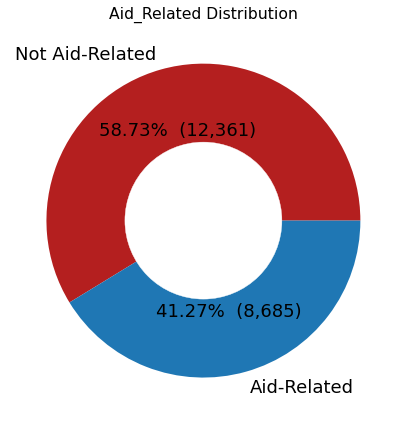

In [27]:
dw.plot_label_distribution('train', 
                           positive_color=COLORS['blue'],
                           negative_color=COLORS['red'],
                           negative_label='Not Aid-Related',
                           positive_label='Aid-Related',
                           title='Aid-Related Value Counts')

### Load Pretrained Vectorizer - GloVe

In [28]:
# Set up total_vocabulary set with all unique words in all texts.
total_vocab = set(
    [word for entry in dw.processed_train[dw.predictive_columns].values 
     for word in entry]
)
print('Total unique words:', len(total_vocab))

Total unique words: 35424


In [29]:
# Load in pretrained GloVe model.
glove = {}

with open('./models/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        line_split = line.split()
        word = line_split[0].decode('utf-8')
        if word in total_vocab:
            word_vector = np.array(line_split[1:], dtype=np.float32)
            glove[word] = word_vector
            
print('Total words loaded from GloVe:', len(glove))

Total words loaded from GloVe: 24792


In [30]:
# Test
glove['earthquake']

array([-0.093032 ,  1.6301   ,  0.36645  ,  0.29015  , -0.81781  ,
       -0.46611  ,  0.037282 ,  0.13208  ,  0.13661  ,  1.2091   ,
        0.81466  , -0.12874  ,  0.52387  , -0.024319 ,  0.94072  ,
       -0.12509  , -0.34087  ,  0.19321  , -1.0522   ,  0.62915  ,
       -0.0699   ,  0.14182  ,  0.49985  ,  0.61688  ,  0.027162 ,
        0.22695  , -0.89086  ,  1.4411   , -0.45774  , -0.5922   ,
        0.48147  , -0.4387   ,  0.99552  ,  1.3003   , -1.1123   ,
       -1.4847   ,  0.53476  , -0.22524  , -0.21366  , -0.14612  ,
       -0.50853  ,  0.82284  , -0.075167 , -0.60331  ,  0.86412  ,
        0.15815  ,  0.76075  , -0.28173  ,  0.27679  , -0.43729  ,
       -0.53438  ,  0.081051 ,  0.98763  , -0.28154  , -0.15944  ,
       -1.9562   ,  0.13058  , -0.46506  ,  1.4629   ,  1.262    ,
       -0.46154  ,  1.3625   , -0.40815  , -0.24256  ,  0.21117  ,
        0.57007  , -1.6566   , -0.21043  ,  0.97449  , -0.16146  ,
       -0.33706  ,  0.50539  ,  0.45718  ,  0.2184   ,  0.6955

### Create Word Vectorizer

In [31]:
# Create model.
word2vec = Word2Vec(dw.X_train(), 
                    size=100, 
                    window=4, 
                    min_count=5, 
                    workers=4)

In [32]:
# Train model.
word2vec.train(dw.X_train(), 
               total_examples=word2vec.corpus_count, 
               epochs=10)

word_vectors = word2vec.wv

In [33]:
# Test model - Most Similar.
for word in ['earthquake', 'help', 'village', 'water', 'people']:
    print(dis.headerize(word.upper()))
    print('Most Similar Words:')
    for i, similar in enumerate(
        [x[0] for x in word_vectors.most_similar(word)], 1):
        print(f'{i}.\t{similar}')
    print()
    print()

********************************************************************************
*                                  EARTHQUAKE                                  *
********************************************************************************
Most Similar Words:
1.	quake
2.	haiti
3.	tsunami
4.	rt
5.	aftershocks
6.	cyclone
7.	7.0
8.	catastrophe
9.	facebook
10.	scale


********************************************************************************
*                                     HELP                                     *
********************************************************************************
Most Similar Words:
1.	whatever
2.	hurry
3.	save
4.	something
5.	christ
6.	advise
7.	relatives
8.	lot
9.	giving
10.	cator


********************************************************************************
*                                   VILLAGE                                    *
********************************************************************************
Most Similar Words:


In [34]:
# Test
word_vectors['earthquake']

array([ 1.3618942 , -1.4378762 , -0.4359392 , -0.9284952 ,  0.10083379,
       -0.86622036, -0.25116476,  1.3478535 ,  1.9203991 ,  0.40740246,
       -0.38427722, -2.1433396 ,  0.13656898,  1.2013257 , -2.1867092 ,
        0.5508775 ,  1.2479264 , -0.39625457,  0.17456402,  0.5956601 ,
        0.0370793 , -0.4810164 ,  1.5068984 ,  0.42474845, -0.98266894,
       -0.48143327,  1.2042216 , -0.4668782 ,  0.503097  , -0.9765428 ,
       -0.5857043 , -2.576836  ,  0.7663045 ,  0.0089225 , -1.3873273 ,
       -0.36681965, -0.23264906, -2.6630466 ,  2.0347626 ,  0.80599433,
       -0.5046309 , -0.15315789, -1.7754698 ,  0.03855809,  2.5144098 ,
        0.8839788 ,  1.5551128 ,  0.60518116,  0.53086656,  1.325947  ,
       -0.6154909 , -1.057441  , -1.0018317 ,  0.13838674, -0.729118  ,
       -0.17755778,  0.09599554, -0.1852888 , -0.07900815, -0.20603001,
       -0.0158615 ,  1.7860416 ,  1.1175631 ,  0.35049605, -0.7343454 ,
        1.2585797 ,  0.7919354 ,  0.6685642 ,  0.02944156, -1.15

### Create TF-IDF Vectorized Data

In [35]:
# # Vectorize data.
# vectorizer = TfidfVectorizer(stop_words=sw)
# vectorizer.fit()

In [36]:
# X_train_tfidf = vectorizer.fit_transform(dw.X_train('all_text')).toarray()
# X_val_tfidf = vectorizer.transform(dw.X_val('all_text')).toarray()
# X_test_tfidf = vectorizer.transform(dw.X_test('all_text')).toarray()

# print('Data Shapes:')
# for array in (X_train_tfidf, X_val_tfidf, X_test_tfidf):
#     print('\t', array.shape)
# # print(f'Vocab Size:\n{len(vectorizer.vocabulary_)}')

In [37]:
# # Test
# X_train_tfidf[vectorizer.vocabulary_['earthquake']]

## EDA

### Length of Messages.

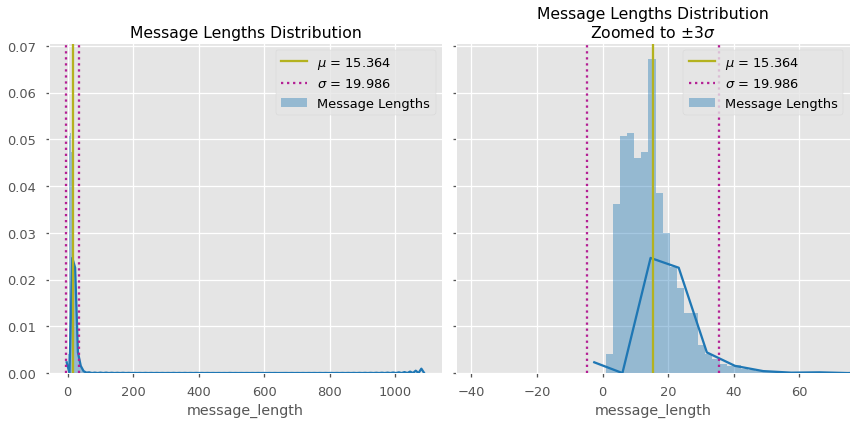

In [38]:
# Series of message lengths.
message_lengths = dw.processed_train[
    dw.predictive_columns].map(lambda x: len(x))
message_lengths.name = 'message_length'

dis.plot_message_lengths_distribution(message_lengths,
                                      dist_color=COLORS['blue'],
                                      mean_color=COLORS['yellow'],
                                      std_color=COLORS['purple'],
                                      pop_label='Message Lengths',
                                      bins=500)

In [39]:
# Examine extreme outliers in length.
message_lengths.sort_values(inplace=True)
longest_10 = message_lengths.tail(10)
shortest_10 = message_lengths.head(10)
print('Longest number of words:')
display(longest_10)
print('Shortest number of words:')
display(shortest_10)

print(dis.headerize('Longest'))
longest_entries = dw.processed_train[
    dw.predictive_columns].loc[longest_10.index].values
print(longest_entries[-1])

print(dis.headerize('Shortest'))
shortest_entries = dw.processed_train[
    dw.predictive_columns].loc[shortest_10.index].values
print(shortest_entries)

Longest number of words:


11828     420
12728     429
16676     467
16926     496
20012     497
13927     579
19916     638
15580     688
16741    1084
12890    1084
Name: message_length, dtype: int64

Shortest number of words:


9819    1
5462    2
7792    2
5739    2
4598    2
7594    2
9740    2
4807    2
7778    2
4944    2
Name: message_length, dtype: int64

********************************************************************************
*                                   Longest                                    *
********************************************************************************
['weather', 'forecast', 'indicates', 'rains', 'go', 'least', 'late', 'december', 'severe', 'drought', 'parching', 'east', 'africa', 'left', '10', 'million', 'facing', 'hunger', 'scope', 'one', 'world', "'s", 'worst', 'unfolding', 'humanitarian', 'disasters', 'conjured', 'memories', 'ethiopia', "'s", 'devastating', '1984', 'famine', 'seismologists', 'agree', 'padang', 'face', 'earthquakes', 'future', 'warn', 'much', 'larger', 'quake', 'far', 'greater', 'destructive', 'force', 'inevitable', 'region', 'flash', 'floods', 'followed', 'torrential', 'monsoonal', 'rains', 'north-west', 'pakistan', '28', '30', 'july', 'caused', 'great', 'loss', 'life', 'wide-spread', 'damage', 'infrastructure', 'livestock', 'property', '100', 'villages', 'lesotho', 'swazil

********************************************************************************
*                                   Shortest                                   *
********************************************************************************
[list(['direct']) list(['paklascencion', 'direct'])
 list(['raped', 'direct']) list(['9geqyeygqeqtm', 'direct'])
 list(['earthquake', 'direct']) list(['earthquake', 'direct'])
 list(['name', 'direct'])
 list(['gjm.adgjmpgjm.adgjmgjmgjmgjmgjmgkmptwptwptwptwptwptwptwptwptwptwpwptwptwgjmgjmgjmad.ad.ad.ad.d.ad.d.da.d.ad.ad.ad', 'direct'])
 list(['sonami', 'direct']) list(['see', 'direct'])]


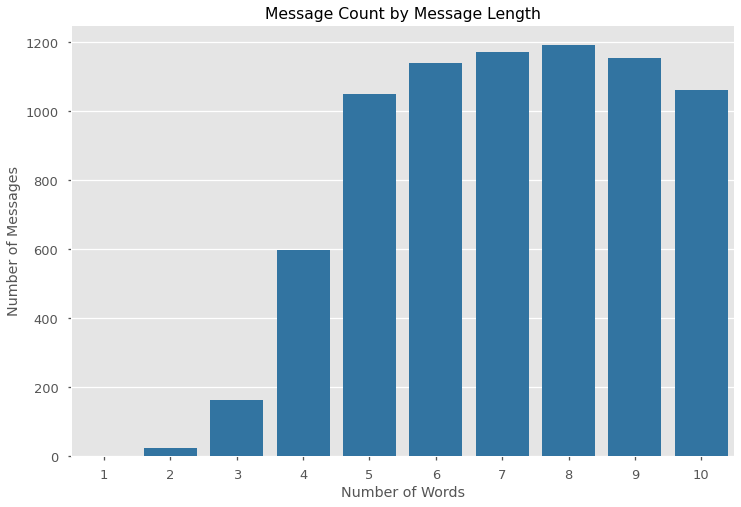

In [40]:
# Plot how many messages contain 10 or fewer words.
x = list(range(1, 10+1))
y = []
for i in x:
    y.append((message_lengths == i).sum())
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, color=COLORS['blue'], ax=ax)
ax.set(title='Message Count by Message Length',
       xlabel='Number of Words',
       ylabel='Number of Messages')
fig.tight_layout()

In [41]:
# Drop messages with fewer than 5 words.
for df in dw.processed_data:
    lengths = df[dw.predictive_columns].map(lambda x: len(x))
    if lengths.index[0] in df.index:
        df.drop(lengths[lengths < 5].index, inplace=True)
        
dw.show_data_shapes()

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(20261, 42)
Processed Val Data:
	(2462, 42)
Processed Test Data:
	(2535, 42)


### Word Frequencies / WordCloud

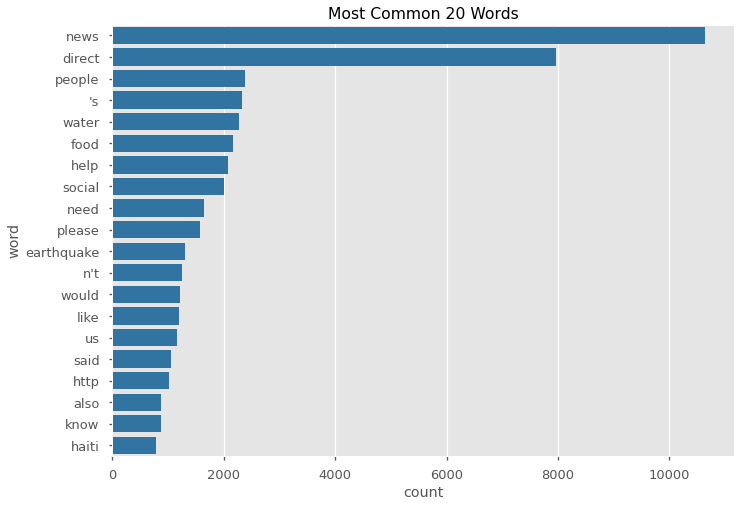

In [42]:
# Plot top 20 words.
all_words = [w for entry in dw.processed_train['all_text_tokenized'].values 
             for w in entry]

freqdist = FreqDist(all_words)
top = pd.DataFrame(freqdist.most_common(20), columns=['word', 'count'])
fig, ax = plt.subplots()
sns.barplot(x='count', y='word', data=top, orient='h', color=COLORS['blue'])
ax.set(title='Most Common 20 Words')
fig.tight_layout()

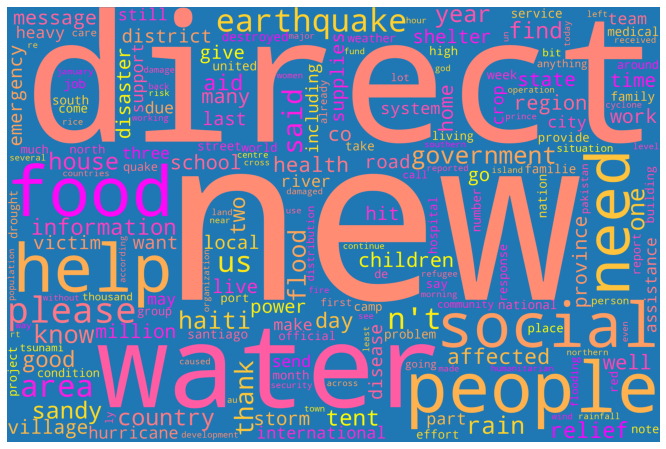

In [43]:
# Create wordcloud.
wordcloud = WordCloud(width=3000, 
                      height=2000, 
                      random_state=51, 
                      background_color=COLORS['blue'], 
                      colormap='spring', 
                      collocations=False).generate(' '.join(all_words))

dis.plot_wordcloud(wordcloud)

### What are the most common words for each label?

********************************************************************************
*                                AID_RELATED_0                                 *
********************************************************************************


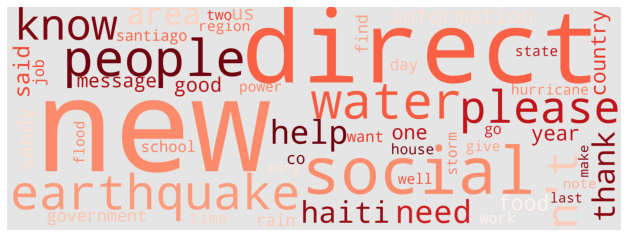

********************************************************************************
*                                AID_RELATED_1                                 *
********************************************************************************


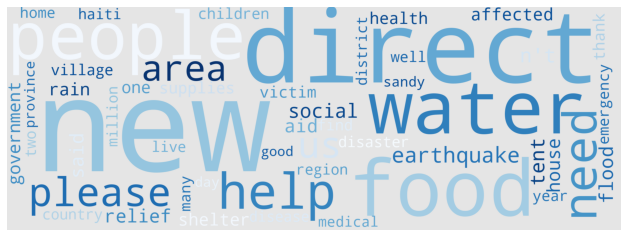

In [44]:
# Create dictionary for each column.
top_10_words = {}
for n in (0, 1):
    col_vocab = [
        word for entry in dw.processed_train[
            dw.processed_train[dw.target_columns] == n
        ]['all_text_tokenized'].values
        for word in entry if word not in sw
    ]
    top_10_words[f'{dw.target_columns}_{str(n)}'] = ' '.join(col_vocab)
    
# Show all wordclouds.
for col in top_10_words:
    wordcloud = WordCloud(width=2200, 
                          height=800, 
                          max_words=50,
                          random_state=51, 
                          background_color=COLORS['grey'], 
                          colormap='Blues' if col.endswith('1') else 'Reds', 
                          collocations=False).generate(top_10_words[col])
    print(dis.headerize(col.upper()))
    dis.plot_wordcloud(wordcloud, figsize=(11,6))

### Phrases - Ngrams

********************************************************************************
*                             Most Common Phrases                              *
********************************************************************************


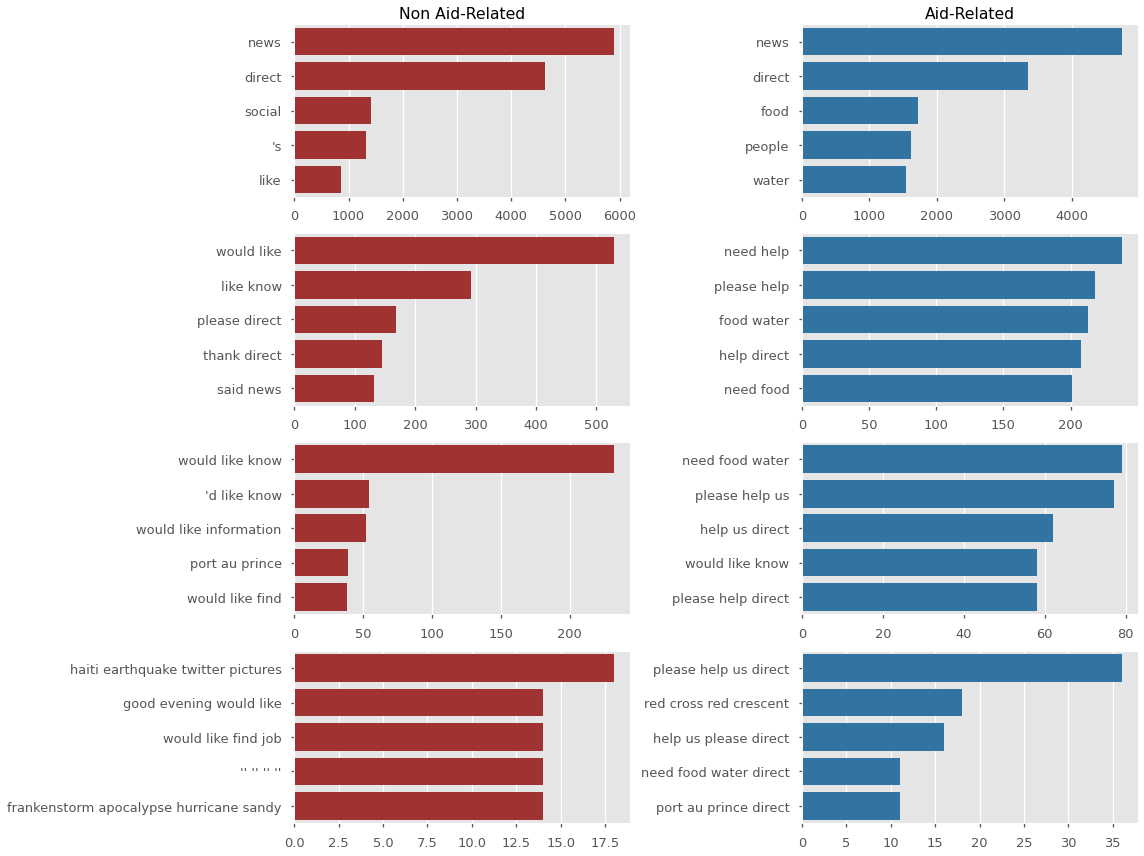

In [45]:
# Get positive and negative labels.
neg = dw.processed_train[
    dw.processed_train[dw.target_columns] == 0][dw.predictive_columns].values
pos = dw.processed_train[
    dw.processed_train[dw.target_columns] == 1][dw.predictive_columns].values

# Plot ngrams.
dis.plot_top_ngrams(4, 
                    pos, neg, 
                    COLORS['blue'], COLORS['red'], 
                    'Aid-Related', 'Non Aid-Related',
                    'Most Common Phrases')

### Word Types - Spacy

In [46]:
# spacey_load = spacy.load('en_core_web_sm')

In [47]:
# # Example.
# print(dis.headerize('Spacy Example'))

# text = dw.processed_train['all_text'][0]
# print(text)

# # Read in text & render 'entitys'.
# ex_spacy = spacey_load(text)
# spacy.displacy.render(ex_spacy, style='ent')

In [48]:
# # Work with a sample of the training data.
# ents_lst = []
# sample = dw.processed_train['all_text'][:10_000]
# total = len(sample)

# # Get total entities found.
# for i, entry in enumerate(sample, 1):
#     if i % 500 == 0:
#         clear_output(wait=True)
#         print(dis.headerize(f'Working: {i} / {total}'))
#     spacey_doc = spacey_load(entry)
#     ents_lst += [x.label_ for x in spacey_doc.ents]

In [49]:
# # Plot top entities from training sample.
# top_10_ents = FreqDist(ents_lst).most_common(10)

# x = []
# y = []
# for ent, count in top_10_ents:
#     x.append(count)
#     y.append(ent)

# fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, color=COLORS['blue'], orient='h')
# ax.set(title='Most Common Word Entities',
#        xlabel='Count',
#        ylabel='Word Entity')
# fig.tight_layout()

# Modeling

## ML - SKLearn

In [50]:
# Create MeanEmbedders
mean_embedder_GLOVE = dis.MeanEmbedder(glove, verbose=True)
mean_embedder_W2V = dis.MeanEmbedder(word_vectors, verbose=True)

Loaded from dictionary.
********************************************************************************
*                                   Success                                    *
********************************************************************************
Embedding model loaded. Dimensions: 100
Loaded from W2V.
********************************************************************************
*                                   Success                                    *
********************************************************************************
Embedding model loaded. Dimensions: 100


#### Classifier Functions

In [51]:
def create_rfc_step_params():
    # RFC pipeline.
    rfc = RandomForestClassifier(n_estimators=100, 
                                 class_weight='balanced', 
                                 random_state=51)
    rfc_step = ('RFC', rfc)

    # RFC GridSearch.
    rfc_params = {
        'RFC__criterion': ['gini', 'entropy'],
        'RFC__min_samples_split': [2, 5, 0.01, 0.05],
        'RFC__max_features': ['sqrt', 'log2', None]
    }
    return (rfc_step, rfc_params)

In [52]:
def create_svc_step_params():
    # SVC pipeline.
    svc = SVC(class_weight='balanced', 
              random_state=51)
    svc_step = ('SVC', svc)

    # SVC GridSearch.
    svc_params = {
        'SVC__C': [0.1, 1., 10.],
        'SVC__kernel': ['poly', 'rbf', 'sigmoid'],
        'SVC__gamma': [0.1, 0.5, 1.]
    }
    return (svc_step, svc_params)

In [53]:
def create_logreg_step_params():
    # LogReg pipeline.
    logreg = LogisticRegression(class_weight='balanced',
                                random_state=51)
    logreg_step = ('LOGREG', logreg)

    logreg_params = {
        'LOGREG__C': [0.1, 1., 10.],
        'LOGREG__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    return (logreg_step, logreg_params)

In [54]:
def make_classifiers_lst():
    return [
        create_rfc_step_params(),
        create_svc_step_params(),
        create_logreg_step_params()
    ]

### MeanWordEmbedder - GloVe

#### Naive Bayes

********************************************************************************
*                             Naive Bayes - GloVe                              *
********************************************************************************
F1 Score:          0.6953818827708703
Accuracy Score:    0.7213647441104792
Recall Score:      0.7616731517509727
Precision Score:   0.6397058823529411


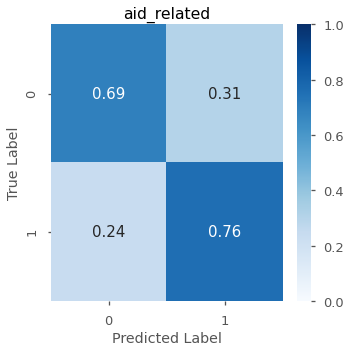

,NB_glove
F1,0.716749
Accuracy,0.727811
Recall,0.767810
Precision,0.672055


In [55]:
# Set up NB Pipeline.
nb = GaussianNB()

ovr_pipe = Pipeline([
    ('MeanWordEmbedder', mean_embedder_GLOVE),
    ('OVR_Logistic_Regression', nb)
])

# Fit / predict.
dis.fit_predict_model(clf=ovr_pipe,
                      X_train=dw.X_train(), 
                      Y_train=dw.Y_train(),
                      X_val=dw.X_val(),
                      Y_val=dw.Y_val(),
                      header='Naive Bayes - GloVe',
                      target_column_names=dw.target_columns,
                      plot_confusion=True)

results_df = assign_scores(
    df=results_df, 
    column_name='NB_glove', 
    scores=dis.get_scores(dw.Y_test(), ovr_pipe.predict(dw.X_test())))
results_df

#### GridSearch

In [56]:
SKLEARN_DIR = './models/sklearn/'

In [57]:
FIT_GLOVE_GRIDSEARCH = False

In [58]:
GLOVE_SUFFIX = '_glove'

if FIT_GLOVE_GRIDSEARCH:
    # Run GridSearch on above model specifications.
    best_glove_estimators_lst = dis.gridsearch_classifiers(
        classifiers=make_classifiers_lst(), 
        mean_word_embedder=mean_embedder_GLOVE, 
        directory=SKLEARN_DIR, 
        X_train=dw.X_train(), 
        Y_train=dw.Y_train(), 
        suffix_label=GLOVE_SUFFIX)
    
# If the files are in the directory.
elif any(
    [f.endswith(f'{GLOVE_SUFFIX}.pkl') for f in os.listdir(SKLEARN_DIR)]
    ):
    # Load in models.
    best_glove_estimators_lst = [
        (name, joblib.load(f'{SKLEARN_DIR}{name}{GLOVE_SUFFIX}.pkl')) 
        for (name, clf), _ in make_classifiers_lst()
    ]

# The models could not be found and `FIT_GLOVE_GRIDSEARCH` is False.
else:
    raise Exception(f'''Models not found in {SKLEARN_DIR}. 
Put the files in the directory or set `FIT_SKLEARN_MODELS` to True''')

********************************************************************************
*                                 RFC - GloVe                                  *
********************************************************************************
F1 Score:          0.7263306641544984
Accuracy Score:    0.7640129975629569
Recall Score:      0.75
Precision Score:   0.7041095890410959


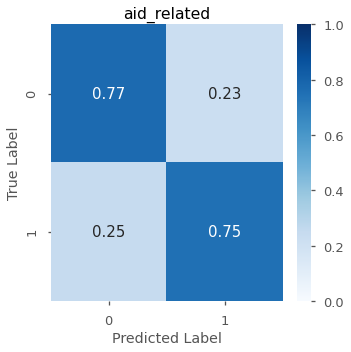

********************************************************************************
*                                 SVC - GloVe                                  *
********************************************************************************
F1 Score:          0.7513611615245008
Accuracy Score:    0.7774167343623071
Recall Score:      0.8054474708171206
Precision Score:   0.7040816326530612


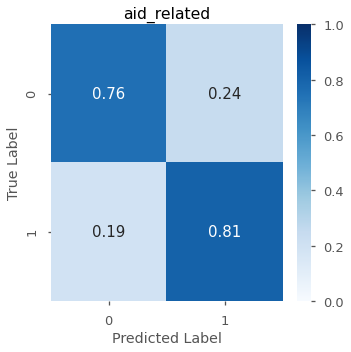

********************************************************************************
*                                LOGREG - GloVe                                *
********************************************************************************
F1 Score:          0.7219954648526076
Accuracy Score:    0.7510154346060114
Recall Score:      0.77431906614786
Precision Score:   0.6762956669498725


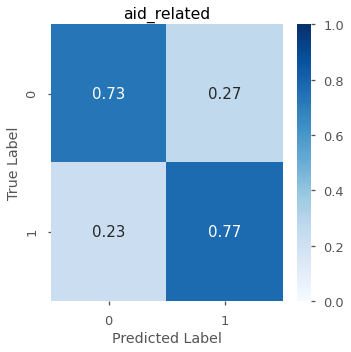

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove
F1,0.716749,0.739593,0.787957,0.749573
Accuracy,0.727811,0.768047,0.805523,0.768836
Recall,0.767810,0.734389,0.805629,0.771328
Precision,0.672055,0.744871,0.771044,0.729011


In [59]:
# Show model scores.
for name, clf in best_glove_estimators_lst:
    dis.show_scores(y_true=dw.Y_val(), 
                    y_pred=clf.predict(dw.X_val()),
                    conf_matrix=True,
                    header=f'{name} - GloVe',
                    column_names=dw.target_columns)
    
    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_glove', 
        scores=dis.get_scores(dw.Y_test(), clf.predict(dw.X_test())))

results_df

### MeanWordEmbedder - Homemade Word Vectorizer

#### Naive Bayes

********************************************************************************
*                            Naive Bayes - Word2Vec                            *
********************************************************************************
F1 Score:          0.6544863987007714
Accuracy Score:    0.6543460601137286
Recall Score:      0.7840466926070039
Precision Score:   0.5616724738675958


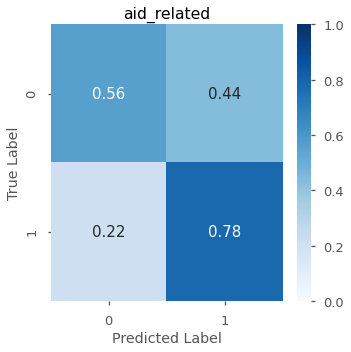

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v
F1,0.716749,0.739593,0.787957,0.749573,0.695079
Accuracy,0.727811,0.768047,0.805523,0.768836,0.689546
Recall,0.767810,0.734389,0.805629,0.771328,0.788918
Precision,0.672055,0.744871,0.771044,0.729011,0.621191


In [60]:
# Set up NB Pipeline.
nb = GaussianNB()

ovr_pipe = Pipeline([
    ('MeanWordEmbedder', mean_embedder_W2V),
    ('OVR_Logistic_Regression', nb)
])

# Fit / predict.
dis.fit_predict_model(clf=ovr_pipe,
                      X_train=dw.X_train(), 
                      Y_train=dw.Y_train(),
                      X_val=dw.X_val(),
                      Y_val=dw.Y_val(),
                      header='Naive Bayes - Word2Vec',
                      target_column_names=dw.target_columns,
                      plot_confusion=True)

results_df = assign_scores(
    df=results_df, 
    column_name='NB_w2v', 
    scores=dis.get_scores(dw.Y_test(), ovr_pipe.predict(dw.X_test())))
results_df

#### GridSearch

In [61]:
FIT_W2V_GRIDSEARCH = False

In [62]:
W2V_SUFFIX = '_w2v'

if FIT_W2V_GRIDSEARCH:
    # Run GridSearch on above model specifications.
    best_w2v_estimators_lst = dis.gridsearch_classifiers(
        classifiers=make_classifiers_lst(), 
        mean_word_embedder=mean_embedder_W2V, 
        directory=SKLEARN_DIR, 
        X_train=dw.X_train(), 
        Y_train=dw.Y_train(), 
        suffix_label=W2V_SUFFIX)
    
# If the files are in the directory.
elif any(
    [f.endswith(f'{W2V_SUFFIX}.pkl') for f in os.listdir(SKLEARN_DIR)]
    ):
    # Load in models.
    best_w2v_estimators_lst = [
        (name, joblib.load(f'{SKLEARN_DIR}{name}{W2V_SUFFIX}.pkl')) 
        for (name, clf), _ in make_classifiers_lst()
    ]

# The models could not be found and `FIT_W2V_GRIDSEARCH` is False.
else:
    raise Exception(f'''Models not found in {SKLEARN_DIR}. 
Put the files in the directory or set `FIT_W2V_GRIDSEARCH` to True''')

********************************************************************************
*                                  RFC - W2V                                   *
********************************************************************************
F1 Score:          0.6956962025316455
Accuracy Score:    0.7558895207148659
Recall Score:      0.6682879377431906
Precision Score:   0.7254487856388595


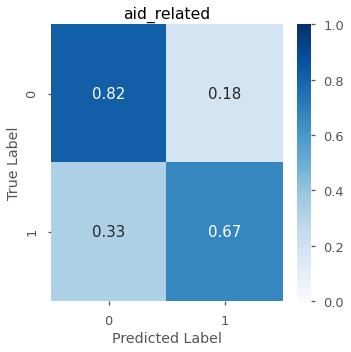

********************************************************************************
*                                  SVC - W2V                                   *
********************************************************************************
F1 Score:          0.7365020766035993
Accuracy Score:    0.7680747359870025
Recall Score:      0.7762645914396887
Precision Score:   0.7006145741878841


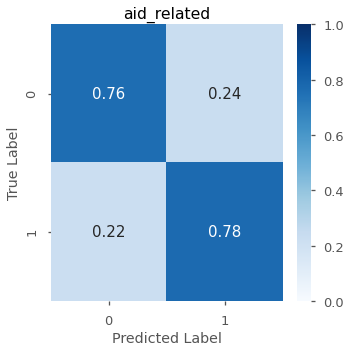

********************************************************************************
*                                 LOGREG - W2V                                 *
********************************************************************************
F1 Score:          0.708801498127341
Accuracy Score:    0.7473598700243704
Recall Score:      0.7363813229571985
Precision Score:   0.6832129963898917


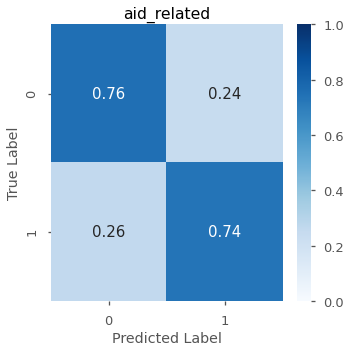

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v
F1,0.716749,0.739593,0.787957,0.749573,0.695079,0.728225,0.765421,0.742634
Accuracy,0.727811,0.768047,0.805523,0.768836,0.689546,0.774753,0.786982,0.765680
Recall,0.767810,0.734389,0.805629,0.771328,0.788918,0.672823,0.774846,0.753738
Precision,0.672055,0.744871,0.771044,0.729011,0.621191,0.793568,0.756223,0.731853


In [63]:
# Show model scores.
for name, clf in best_w2v_estimators_lst:
    dis.show_scores(y_true=dw.Y_val(), 
                    y_pred=clf.predict(dw.X_val()),
                    conf_matrix=True,
                    header=f'{name} - W2V',
                    column_names=dw.target_columns)
    
    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}{W2V_SUFFIX}', 
        scores=dis.get_scores(dw.Y_test(), clf.predict(dw.X_test())))

results_df

### TF-IDF Words Model

#### Multinomial Naive Bayes

In [64]:
# # Fit / predict.
# nb = MultinomialNB()

# dis.fit_predict_model(clf=nb,
#                       X_train=X_train_tfidf, 
#                       Y_train=dw.Y_train(),
#                       X_val=X_val_tfidf,
#                       Y_val=dw.Y_val(),
#                       header='Naive Bayes - TF-IDF',
#                       plot_confusion=True)

# results_df = assign_scores(
#     df=results_df, 
#     column_name='NB_tfidf', 
#     scores=dis.get_scores(dw.Y_test(), nb.predict(X_test_tfidf)))
# results_df

In [65]:
# FIT_TFIDF_GRIDSEARCH = True

In [66]:
# TFIDF_SUFFIX = '_tfidf'

# if FIT_TFIDF_GRIDSEARCH:
#     best_tfidf_estimators_lst = []
#     for (name, clf), clf_params in make_classifiers_lst():
#         clf_grid = GridSearchCV(clf, 
#                                 clf_params, 
#                                 cv=3, 
#                                 n_jobs=-2, 
#                                 verbose=True)
#         clf_grid.fit(X_train_tfidf, dw.Y_train())
        
#         # Fit & save.
#         clf_grid.fit(X_train, Y_train)
#         save_lst.append(
#             (name, clf_grid.best_estimator_)
#         )
#         joblib.dump(clf_grid.best_estimator_, 
#                     f'{SKLEARN_DIR}{name}{TFIDF_SUFFIX}.pkl')

In [67]:
# if FIT_VEC:
#     # Fit Random Forest on vectorized data.
#     rfc = RandomForestClassifier()
#     dis.fit_predict_model(clf=rfc,
#                           X_train=X_train_vec, 
#                           Y_train=dw.Y_train(),
#                           X_val=X_val_vec,
#                           Y_val=dw.Y_val(),
#                           header=f'Vectorized Data - RFC',
#                           return_pred=False,
#                           plot_confusion=False)
    
#     ## Plot Feature Importance
#     importance = pd.Series(rfc.feature_importances_,
#                            index=vectorizer.get_feature_names())

#     ## Take the .tail 30 and plot kind='barh'
#     fig, ax = plt.subplots()
#     importance.sort_values().tail(30).plot(kind='barh', ax=ax)
#     ax.set(title='RFC Most Important Words',
#            ylabel='Word')
#     fig.tight_layout()

## TensorFlow Neural Network

In [68]:
def build_simple_nn():
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [69]:
def build_multilayer_nn(dense_layers=10):
    node_sizes = [2] # Minimum nodes in last layer.
    for _ in range(dense_layers-1):
        node_sizes.append(int(node_sizes[-1] + (node_sizes[-1] * 0.75)))
    print(dis.headerize(f'Nodes Per Layer: {node_sizes[::-1]}'))
    
    model = models.Sequential()
    for n in node_sizes[::-1]:
        model.add(layers.Dense(n, activation='relu'))
        model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [70]:
# Metrics
metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

### MeanWordEmbedder - GloVe

In [71]:
# Set up data.
X_train_glove = mean_embedder_GLOVE.transform(dw.X_train())
X_val_glove = mean_embedder_GLOVE.transform(dw.X_val())
X_test_glove = mean_embedder_GLOVE.transform(dw.X_test())

X_train_glove.shape, X_val_glove.shape, X_test_glove.shape

((20261, 100), (2462, 100), (2535, 100))

In [72]:
# Create models.
simple_glove_model = build_simple_nn()
multilayer_glove_model = build_multilayer_nn(6)

for model in (simple_glove_model, multilayer_glove_model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

********************************************************************************
*                    Nodes Per Layer: [24, 14, 8, 5, 3, 2]                     *
********************************************************************************


In [73]:
TRAIN_GLOVE_NN = False

In [74]:
simple_glove_cp_path = './models/model_callbacks/simple_glove_model/cp.ckpt'
multilayer_glove_cp_path = './models/model_callbacks/multilayer_glove_model/cp.ckpt'
sim_cp_dir = os.path.dirname(simple_glove_cp_path)
ml_cp_dir = os.path.dirname(multilayer_glove_cp_path)

if TRAIN_GLOVE_NN:
    simple_glove_history = dis.train_dump_model(
        name='simple_model', 
        model=simple_glove_model, 
        X_train=X_train_glove, 
        y_train=dw.Y_train(), 
        X_val=X_val_glove, 
        y_val=dw.Y_val(), 
        checkpoint_path=simple_glove_cp_path
        )
    multilayer_glove_history = dis.train_dump_model(
        name='multilayer_model', 
        model=multilayer_glove_model, 
        X_train=X_train_glove, 
        y_train=dw.Y_train(), 
        X_val=X_val_glove, 
        y_val=dw.Y_val(), 
        checkpoint_path=multilayer_glove_cp_path
        )
else:
    simple_glove_model.load_weights(simple_glove_cp_path)
    multilayer_glove_model.load_weights(multilayer_glove_cp_path)
    
    simple_glove_history = joblib.load(
        sim_cp_dir+'/simple_model_history.pkl')
    multilayer_glove_history = joblib.load(
        ml_cp_dir+'/multilayer_model_history.pkl')

********************************************************************************
*                       simple_model - NN - MWE - GloVe                        *
********************************************************************************


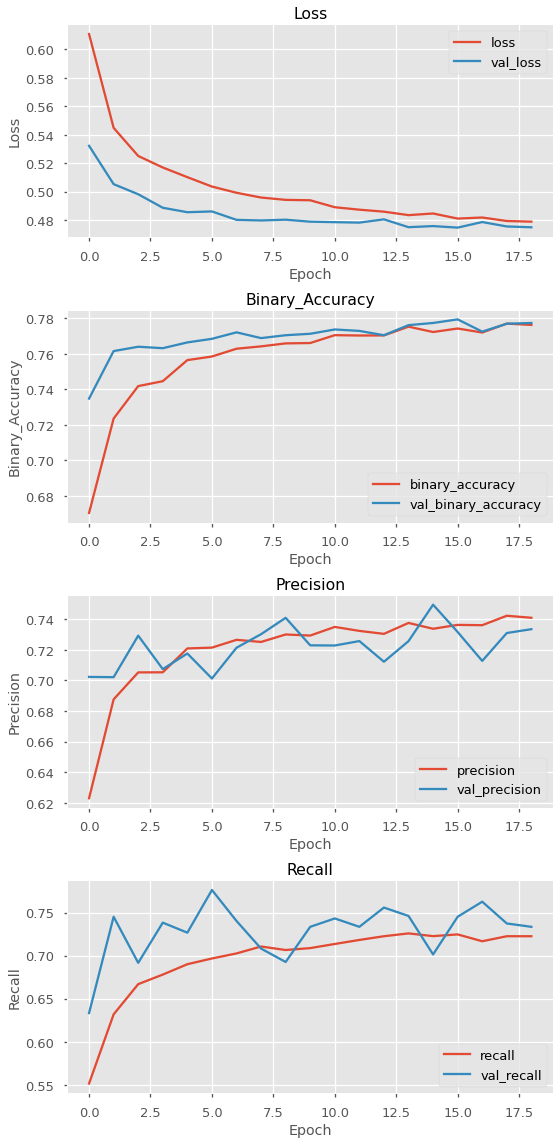

********************************************************************************
*    Optimal Threshold: 0.30000000000000004. Top Score: 0.7393483709273183     *
********************************************************************************
********************************************************************************
*                       simple_model - NN - MWE - GloVe                        *
********************************************************************************
F1 Score:          0.7393483709273183
Accuracy Score:    0.7465475223395613
Recall Score:      0.8608949416342413
Precision Score:   0.6478770131771596


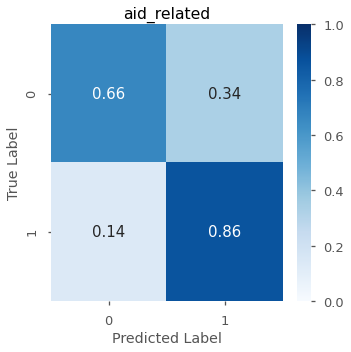

********************************************************************************
*                     multilayer_model - NN - MWE - GloVe                      *
********************************************************************************


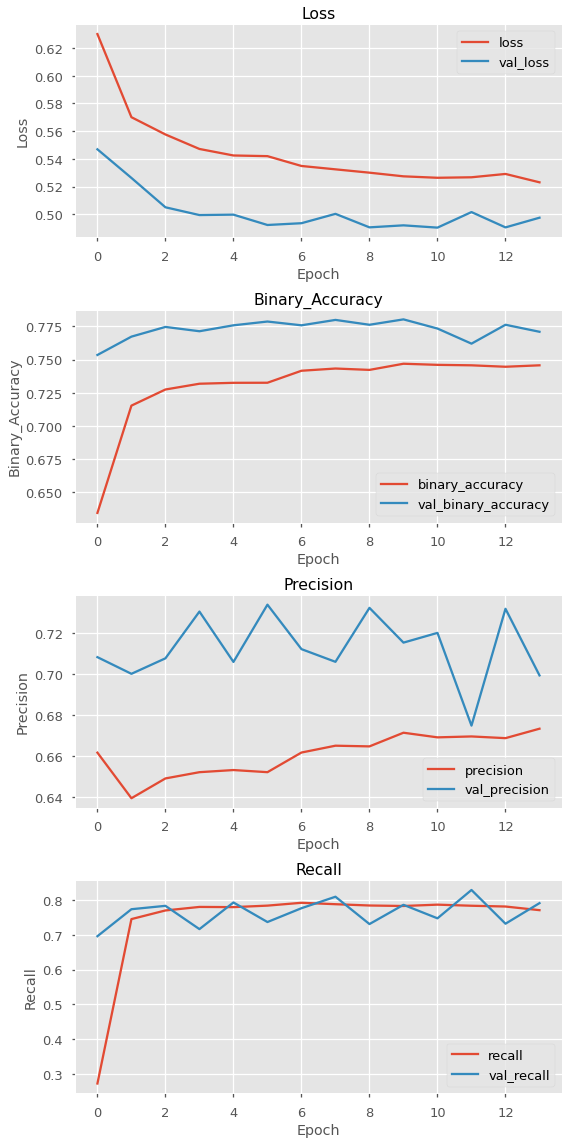

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


********************************************************************************
*            Optimal Threshold: 0.4. Top Score: 0.7463312368972745             *
********************************************************************************
********************************************************************************
*                     multilayer_model - NN - MWE - GloVe                      *
********************************************************************************
F1 Score:          0.7463312368972745
Accuracy Score:    0.7542648253452477
Recall Score:      0.8657587548638133
Precision Score:   0.6558585114222549


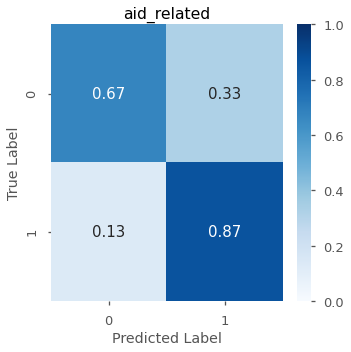

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove
F1,0.716749,0.739593,0.787957,0.749573,0.695079,0.728225,0.765421,0.742634,0.775526,0.772781
Accuracy,0.727811,0.768047,0.805523,0.768836,0.689546,0.774753,0.786982,0.765680,0.772781,0.770809
Recall,0.767810,0.734389,0.805629,0.771328,0.788918,0.672823,0.774846,0.753738,0.875110,0.868953
Precision,0.672055,0.744871,0.771044,0.729011,0.621191,0.793568,0.756223,0.731853,0.696291,0.695775


In [75]:
glove_nn_lst = [
    ('simple_model', simple_glove_model, simple_glove_history),
    ('multilayer_model', multilayer_glove_model, multilayer_glove_history)
]

for name, model, history in glove_nn_lst:
    y_test_pred = dis.evaluate_nn(model, 
                                  history, 
                                  X_val_glove, 
                                  dw.Y_val(), 
                                  X_test_glove, 
                                  header=f'{name} - NN - MWE - GloVe', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_NN_glove', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

### MeanWordEmbedder - Homemade Word Vectorizer

In [76]:
# Set up data.
X_train_w2v = mean_embedder_W2V.transform(dw.X_train())
X_val_w2v = mean_embedder_W2V.transform(dw.X_val())
X_test_w2v = mean_embedder_W2V.transform(dw.X_test())

X_train_w2v.shape, X_val_w2v.shape, X_test_w2v.shape

((20261, 100), (2462, 100), (2535, 100))

In [77]:
# Create models.
simple_w2v_model = build_simple_nn()
multilayer_w2v_model = build_multilayer_nn(6)

for model in (simple_w2v_model, multilayer_w2v_model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

********************************************************************************
*                    Nodes Per Layer: [24, 14, 8, 5, 3, 2]                     *
********************************************************************************


In [78]:
TRAIN_W2V_NN = False

In [79]:
simple_w2v_cp_path = './models/model_callbacks/simple_w2v_model/cp.ckpt'
multilayer_w2v_cp_path = './models/model_callbacks/multilayer_w2v_model/cp.ckpt'
sim_cp_dir = os.path.dirname(simple_w2v_cp_path)
ml_cp_dir = os.path.dirname(multilayer_w2v_cp_path)

if TRAIN_W2V_NN:
    simple_w2v_history = dis.train_dump_model(
        name='simple_model', 
        model=simple_w2v_model, 
        X_train=X_train_w2v, 
        y_train=dw.Y_train(), 
        X_val=X_val_w2v, 
        y_val=dw.Y_val(), 
        checkpoint_path=simple_w2v_cp_path
        )
    multilayer_w2v_history = dis.train_dump_model(
        name='multilayer_model', 
        model=multilayer_w2v_model, 
        X_train=X_train_w2v, 
        y_train=dw.Y_train(), 
        X_val=X_val_w2v, 
        y_val=dw.Y_val(), 
        checkpoint_path=multilayer_w2v_cp_path
        )
else:
    simple_w2v_model.load_weights(simple_w2v_cp_path)
    multilayer_w2v_model.load_weights(multilayer_w2v_cp_path)
    
    simple_w2v_history = joblib.load(
        sim_cp_dir+'/simple_model_history.pkl')
    multilayer_w2v_history = joblib.load(
        ml_cp_dir+'/multilayer_model_history.pkl')

Epoch 1/50

Epoch 00001: saving model to ./models/model_callbacks/simple_w2v_model\cp.ckpt
634/634 - 6s - loss: 0.6062 - binary_accuracy: 0.6647 - precision: 0.6569 - recall: 0.4298 - val_loss: 0.5469 - val_binary_accuracy: 0.7327 - val_precision: 0.6789 - val_recall: 0.6829
Epoch 2/50

Epoch 00002: saving model to ./models/model_callbacks/simple_w2v_model\cp.ckpt
634/634 - 9s - loss: 0.5580 - binary_accuracy: 0.7238 - precision: 0.6842 - recall: 0.6412 - val_loss: 0.5329 - val_binary_accuracy: 0.7461 - val_precision: 0.6970 - val_recall: 0.6936
Epoch 3/50

Epoch 00003: saving model to ./models/model_callbacks/simple_w2v_model\cp.ckpt
634/634 - 8s - loss: 0.5450 - binary_accuracy: 0.7315 - precision: 0.6931 - recall: 0.6525 - val_loss: 0.5218 - val_binary_accuracy: 0.7502 - val_precision: 0.7080 - val_recall: 0.6839
Epoch 4/50

Epoch 00004: saving model to ./models/model_callbacks/simple_w2v_model\cp.ckpt
634/634 - 6s - loss: 0.5352 - binary_accuracy: 0.7395 - precision: 0.7048 - recal

********************************************************************************
*                        simple_model - NN - MWE - W2V                         *
********************************************************************************


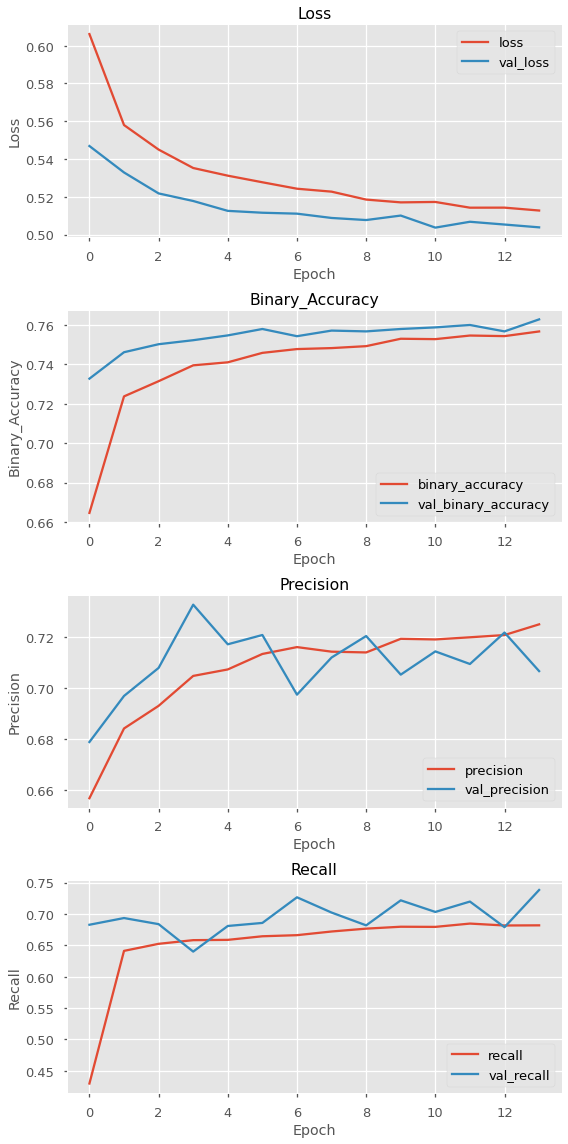

********************************************************************************
*            Optimal Threshold: 0.4. Top Score: 0.7269519188354653             *
********************************************************************************
********************************************************************************
*                        simple_model - NN - MWE - W2V                         *
********************************************************************************
F1 Score:          0.7269519188354653
Accuracy Score:    0.7485783915515841
Recall Score:      0.8015564202334631
Precision Score:   0.6650524616626311


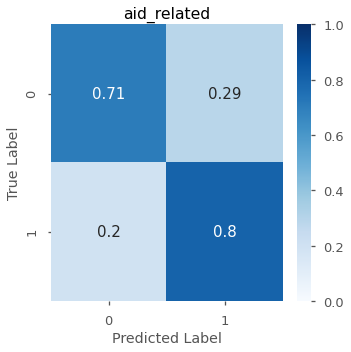

********************************************************************************
*                      multilayer_model - NN - MWE - W2V                       *
********************************************************************************


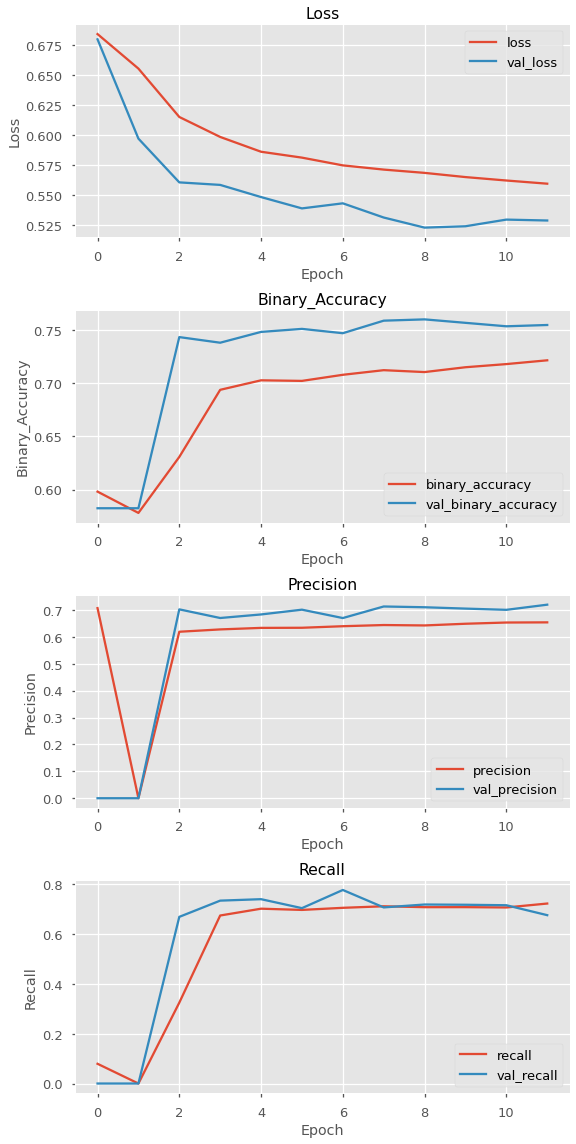

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


********************************************************************************
*            Optimal Threshold: 0.4. Top Score: 0.7166361974405849             *
********************************************************************************
********************************************************************************
*                      multilayer_model - NN - MWE - W2V                       *
********************************************************************************
F1 Score:          0.7166361974405849
Accuracy Score:    0.7481722177091795
Recall Score:      0.7626459143968871
Precision Score:   0.6758620689655173


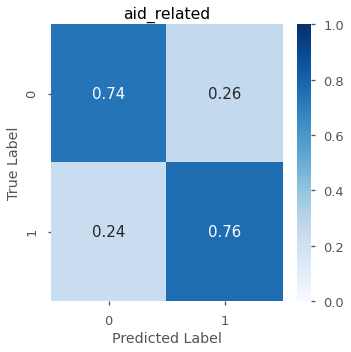

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove,simple_model_NN_w2v,multilayer_model_NN_w2v
F1,0.716749,0.739593,0.787957,0.749573,0.695079,0.728225,0.765421,0.742634,0.775526,0.772781,0.758165,0.763841
Accuracy,0.727811,0.768047,0.805523,0.768836,0.689546,0.774753,0.786982,0.765680,0.772781,0.770809,0.769231,0.784615
Recall,0.767810,0.734389,0.805629,0.771328,0.788918,0.672823,0.774846,0.753738,0.875110,0.868953,0.806508,0.776605
Precision,0.672055,0.744871,0.771044,0.729011,0.621191,0.793568,0.756223,0.731853,0.696291,0.695775,0.715289,0.751489


In [80]:
w2v_nn_lst = [
    ('simple_model', simple_w2v_model, simple_w2v_history),
    ('multilayer_model', multilayer_w2v_model, multilayer_w2v_history)
]

for name, model, history in w2v_nn_lst:
    y_test_pred = dis.evaluate_nn(model, 
                                  history, 
                                  X_val_w2v, 
                                  dw.Y_val(), 
                                  X_test_w2v, 
                                  header=f'{name} - NN - MWE - W2V', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_NN_w2v', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

### Padded & Tokenized - RNN

#### Processing

In [81]:
# Create padded tokens of 'all_text' from DataWarehouse.
all_text_lst = [dw.X_train(), dw.X_val(), dw.X_test()]
max_length = 65

tokenizer, (X_train_tok, X_val_tok, X_test_tok) = dis.tokenize_series(
    dw.X_train(),
    all_text_lst,
    pad_sequences_maxlen=max_length)

********************************************************************************
*                           Tokenizer Created & Fit                            *
********************************************************************************
Ex:


[['weather',
  'update',
  'cold',
  'front',
  'cuba',
  'could',
  'pass',
  'haiti',
  'direct'],
 ['says',
  'west',
  'side',
  'haiti',
  'rest',
  'country',
  'today',
  'tonight',
  'direct']]

********************************************************************************
*                              Series' Tokenized                               *
********************************************************************************
Ex:


[[112, 1810, 337, 841, 2504, 60, 465, 20, 2],
 [408, 250, 858, 20, 1197, 25, 166, 1044, 2]]

********************************************************************************
*                                  Tokenized                                   *
********************************************************************************
Ex:


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  112, 1810,  337,  841, 2504,   60,  465,   20,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  408,  250,  858,   20, 1197,   25,  166, 1044,    2]])

********************************************************************************
*                                   Finished                                   *
********************************************************************************


In [82]:
# Create w2v dictionary in same format as glove.
w2v_dct = {word: word_vectors[word] for word in word_vectors.vocab}

In [83]:
# Set num_words & embedding size for models.
glove_vocab_len, glove_n_dim, glove_matrix = dis.make_embedding_matrix(
    glove, tokenizer.word_index)
w2v_vocab_len, w2v_n_dim, w2v_matrix = dis.make_embedding_matrix(
    w2v_dct, tokenizer.word_index)

In [84]:
glove_matrix.shape, w2v_matrix.shape

((35298, 100), (35298, 100))

In [85]:
# Set variables for modeling.
rnn_glove_path = 'models/model_callbacks/rnn_glove/cp.ckpt'
rnn_w2v_path = 'models/model_callbacks/rnn_w2v/cp.ckpt'

rnn_dct = {
    'glove': {'model': None, 
              'history': None,
              'params': (glove_vocab_len, glove_n_dim, glove_matrix),
              'path': rnn_glove_path,
              'dir': os.path.dirname(rnn_glove_path)},
    'w2v': {'model': None, 
            'history': None,
            'params': (w2v_vocab_len, w2v_n_dim, w2v_matrix),
            'path': rnn_w2v_path,
            'dir': os.path.dirname(rnn_w2v_path)}
}

In [86]:
for name in rnn_dct:
    vocab_len, n_dim, matrix = rnn_dct[name]['params']
    
    model = models.Sequential()
    model.add(layers.Embedding(vocab_len, 
                               n_dim, 
                               weights=[matrix], 
                               input_length=max_length, 
                               trainable=False))
    model.add(layers.GRU(n_dim, 
                         batch_size=1, 
                         input_shape=(None, n_dim), 
                         return_sequences=True))
    # rnn_glove_model.add(layers.LSTM(glove_n_dim, 
    #                                 batch_size=1, 
    #                                 input_shape=(None, glove_n_dim), 
    #                                 return_sequences=True))
    model.add(layers.TimeDistributed(
    layers.Dense(10, activation='relu')))
    model.add(layers.Dropout(0.1))
    model.add(layers.TimeDistributed(
    layers.Dense(8, activation='relu')))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    rnn_dct[name]['model'] = model

In [87]:
TRAIN_RNN = False

In [88]:
if TRAIN_RNN:
    for name in rnn_dct:
        model_history = dis.train_dump_model(
            name=f'rnn_{name}', 
            model=rnn_dct[name]['model'], 
            X_train=X_train_tok, 
            y_train=dw.Y_train(), 
            X_val=X_val_tok, 
            y_val=dw.Y_val(), 
            checkpoint_path=rnn_dct[name]['path']
            )
        rnn_dct[name]['history'] = model_history
else:
    for name in rnn_dct:
        rnn_dct[name]['model'].load_weights(rnn_dct[name]['path'])
        rnn_dct[name]['history'] = joblib.load(
            rnn_dct[name]['dir']+f'/rnn_{name}_history.pkl')

********************************************************************************
*                                 RNN - glove                                  *
********************************************************************************


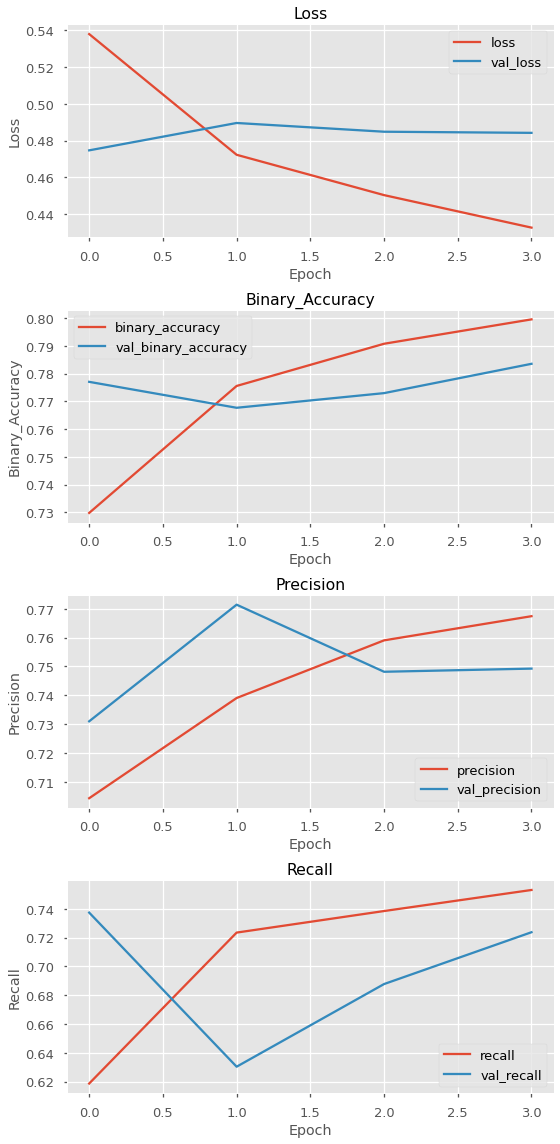

********************************************************************************
*    Optimal Threshold: 0.30000000000000004. Top Score: 0.7469352014010509     *
********************************************************************************
********************************************************************************
*                                 RNN - glove                                  *
********************************************************************************
F1 Score:          0.7469352014010509
Accuracy Score:    0.7652315190901706
Recall Score:      0.8297665369649806
Precision Score:   0.679140127388535


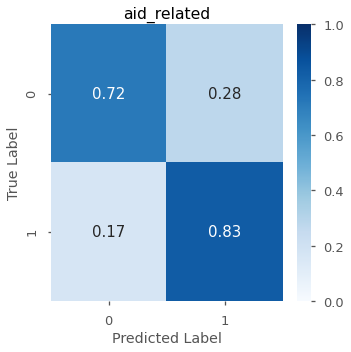

********************************************************************************
*                                  RNN - w2v                                   *
********************************************************************************


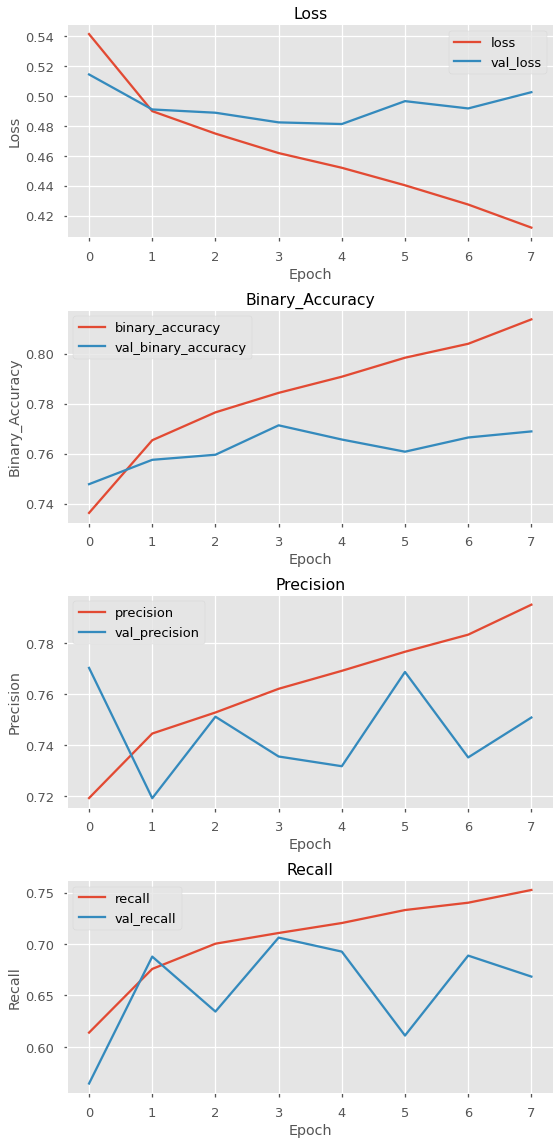

********************************************************************************
*     Optimal Threshold: 0.30000000000000004. Top Score: 0.732568402471315     *
********************************************************************************
********************************************************************************
*                                  RNN - w2v                                   *
********************************************************************************
F1 Score:          0.732568402471315
Accuracy Score:    0.7538586515028433
Recall Score:      0.8073929961089494
Precision Score:   0.6704361873990307


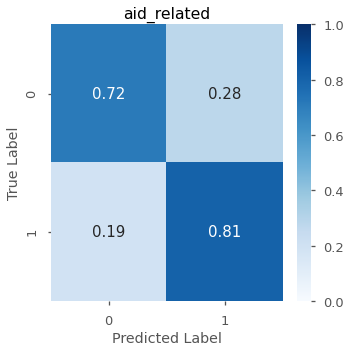

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove,simple_model_NN_w2v,multilayer_model_NN_w2v,rnn_glove,rnn_w2v
F1,0.716749,0.739593,0.787957,0.749573,0.695079,0.728225,0.765421,0.742634,0.775526,0.772781,0.758165,0.763841,0.798347,0.781818
Accuracy,0.727811,0.768047,0.805523,0.768836,0.689546,0.774753,0.786982,0.765680,0.772781,0.770809,0.769231,0.784615,0.807495,0.791716
Recall,0.767810,0.734389,0.805629,0.771328,0.788918,0.672823,0.774846,0.753738,0.875110,0.868953,0.806508,0.776605,0.849604,0.832014
Precision,0.672055,0.744871,0.771044,0.729011,0.621191,0.793568,0.756223,0.731853,0.696291,0.695775,0.715289,0.751489,0.752923,0.737334


In [89]:
for name in rnn_dct:
    y_test_pred = dis.evaluate_nn(rnn_dct[name]['model'], 
                                  rnn_dct[name]['history'], 
                                  X_val_tok, 
                                  dw.Y_val(), 
                                  X_test_tok, 
                                  header=f'RNN - {name}', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'RNN_{name}', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

# Interpret

In [137]:
results_df = results_df.T
results_df.sort_values('F1', ascending=False, inplace=True)

In [138]:
results_df.style.background_gradient('Blues')
# results_df.style.bar(color=COLORS['blue'])
# results_df.style.highlight_max()

,F1,Accuracy,Recall,Precision
rnn_glove,0.798347,0.807495,0.849604,0.752923
SVC_glove,0.787957,0.805523,0.805629,0.771044
rnn_w2v,0.781818,0.791716,0.832014,0.737334
simple_model_NN_glove,0.775526,0.772781,0.87511,0.696291
multilayer_model_NN_glove,0.772781,0.770809,0.868953,0.695775
SVC_w2v,0.765421,0.786982,0.774846,0.756223
multilayer_model_NN_w2v,0.763841,0.784615,0.776605,0.751489
simple_model_NN_w2v,0.758165,0.769231,0.806508,0.715289
LOGREG_glove,0.749573,0.768836,0.771328,0.729011
LOGREG_w2v,0.742634,0.76568,0.753738,0.731853


## Deployment

> - "How did you pick the question(s) that you did?"
- "Why are these questions important from a business perspective?"
- "How did you decide on the data cleaning options you performed?"
- "Why did you choose a given method or library?"
- "Why did you select these visualizations and what did you learn from each of them?"
- "Why did you pick those features as predictors?"
- "How would you interpret the results?"
- "How confident are you in the predictive quality of the results?"
- "What are some of the things that could cause the results to be wrong?"

# JUNK
#### Keras Tuner - Hyperband

In [101]:
# RUN_TUNER = False

In [102]:
# if RUN_TUNER:
#     keras_tuner_dir = './models/keras_tuner'
    
#     tuner = dis.keras_tuner_hyperband(X_train_tok,
#                                       dw.Y_train(),
#                                       X_val_tok, 
#                                       dw.Y_val(),
#                                       directory=keras_tuner_dir)
    
#     best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
#     model = tuner.hypermodel.build(best_hps)
#     model.fit(X_train_tok, 
#               dw.Y_train(), 
#               epochs=10, 
#               batch_size=32, 
#               validation_data=(X_val_tok, 
#                                dw.Y_val()))

```
********************************************************************************
*                               Tuning Complete                                *
********************************************************************************
Optimal Settings:
	GRU UNITS           : 224
	DENSE UNITS         : 416
	LEARNING RATE       : 0.001
    ```

In [103]:
# GRU_UNITS = 224
# DENSE_UNITS = 416
# LEARNING_RATE = 0.001

In [104]:
# # Build optimal model.
# gru_tuned_model = dis.build_model(num_words, 
#                                   embedding_size,
#                                   gru=True,
#                                   gru_units=GRU_UNITS,
#                                   dense_units=DENSE_UNITS,
#                                   learning_rate=LEARNING_RATE)
# gru_tuned_model.summary()

In [105]:
# TRAIN_GRU_TUNED = False

In [106]:
# gru_tuned_checkpoint_path = "models/model_callbacks/gru_tuned/cp.ckpt"
# gru_tuned_checkpoint_dir = os.path.dirname(gru_tuned_checkpoint_path)

# if TRAIN_GRU_TUNED:
#     # Create a callback that saves the model's weights
#     gru_tuned_callback = ModelCheckpoint(filepath=gru_tuned_checkpoint_path,
#                                          save_weights_only=True,
#                                          verbose=1)

#     gru_tuned_model_history = gru_tuned_model.fit(
#         X_train_tok, 
#         dw.Y_train(), 
#         epochs=5, 
#         batch_size=32, 
#         validation_data=(X_val_tok, dw.Y_val()),
#         callbacks=[gru_tuned_callback])

# elif os.listdir(gru_tuned_checkpoint_dir):
#     # Load in pretrained weights.
#     gru_tuned_model.load_weights(gru_tuned_checkpoint_path)

In [107]:
# # Find optimal prediction threshold.
# y_val_pred = gru_tuned_model.predict(X_val_tok)

# dis.fit_thresholds(dw.Y_val(), y_val_pred, 'f1_score')